# finding a function with machine learning

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lib import make_line

In [2]:
df = pd.read_csv('../data/fashion.csv')
df.head()

,Weight,Size
0,50.000000,108.440055
1,51.010101,141.287516
2,52.020202,150.825342
3,53.030303,151.644268
4,54.040404,159.596465


In [3]:
# we will use scikit-learn's LinearRegression
from sklearn.linear_model import LinearRegression

# note the double brackets for X -- this is necessary to get X in the right format/shape
X = df[['Weight']]
y = df['Size']

# create the model and "fit" it to the data (i.e. find the parameters, m & b, for us)
# we'll go into more detail how this works in a little bit.
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [4]:
# what value's for m and b did we learn?
m = model.coef_[0]
b = model.intercept_

print('m', m)
print('b', b)

m 1.86488241361
b 43.7111459091


So our algorithm gave us m=1.8,b=50 back and thus we have learned the function:

$$
y = 1.86x + 43.7
$$

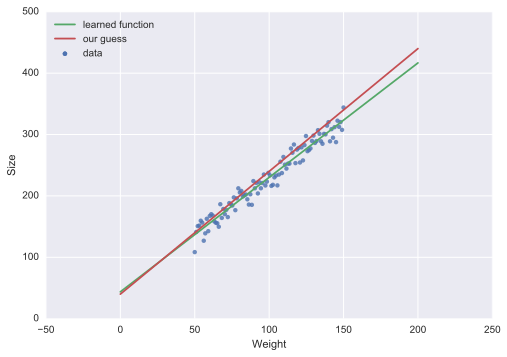

In [7]:
# what does this line look like?
sns.regplot(df['Weight'], df['Size'], fit_reg=False)
xs, ys = make_line(m, b)
plt.plot(xs, ys)
xs, ys = make_line(2, 40)
plt.plot(xs, ys)
plt.legend(['learned function', 'our guess', 'data'], loc=2)

it looks pretty good - but how do we know if this is actually a better fit?

can we quantify "good-fittedness"?


# yes we can 👍🏽

there are a lot of different ways, but the general idea is to quantify how "wrong" our guessed function (the "hypothesis") is

we can look at each data point and see how far off it is from the line we guessed, e.g.

![](assets/error.png)

to figure out how wrong we are across _all_ the data points, we can just get the average (mean) of these errors.

we might also want to penalize bigger errors more, so we could first square these errors. that way big errors become really big, and small errors stay small-ish.

In [10]:
def wrongness(m, b, xs, true_ys):
    pred_ys = m * xs + b
    error = true_ys - pred_ys
    sq_error = error**2
    return np.mean(sq_error)

wrongness(m, b, df['Weight'], df['Size'])

135.89602623791365

these "wrongness" functions are known as _cost functions_ (sometimes you'll seem them called _objective functions_ or _loss functions_). there are many different kinds! the one we came up with is called _mean squared error_ (which is what we did, took the mean of the squared errors).

In [9]:
# scikit-learn has this built-in, you'll see it gives the same answer
from sklearn import metrics
y_pred = model.predict(X)
metrics.mean_squared_error(y_pred, y)

135.89602623791365

In [10]:
# roughly normalize to get a sense of relative error
metrics.mean_squared_error(y_pred, y)/np.mean(y)

0.59034052110108082

0.657938775061925

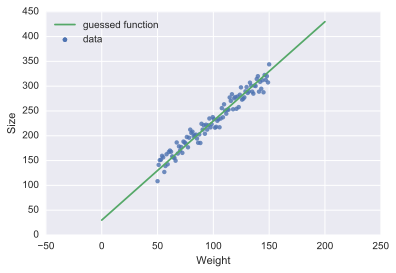

In [13]:
# let's see what the MSE is for other line guesses
sns.regplot(df['Weight'], df['Size'], fit_reg=False)

# =====================
guess_m, guess_b = 2, 30
# =====================

xs, ys = make_line(guess_m, guess_b)
plt.plot(xs, ys)
plt.legend([], loc=2)
plt.legend(['guessed function', 'data'], loc=2)

pred_ys = guess_m * X + guess_b
metrics.mean_squared_error(pred_ys, y)/np.mean(y)

the line the linear regression algorithm learned is a pretty good fit!

in fact, he function I used to generate the data was:

$$
y = 1.8x + 50
$$

so it's very close.

but it's error is still pretty far from 0. don't we want it to get as close to 0 as possible?

#  ✋🏽 hold on: not necessarily

yes, you normally want to get your error as low as possible, but we're doing something incorrectly in this example.

you should not evaluate a model's performance on the data used to train it - if you evaluate this way, the model may _overfit_, that is, start to capture the idiosyncracies of the training data, which may not reflect the more general process you are trying to describe (we want our function to _generalize_ to new data). the best practice is to set aside some of your data for validation and use that to evaluate your model.

to bring it back to fashion, you want your pants to fit everyone at a certain weight pretty well. overfitting is where the pants fits one person really, really well, and is a terrible fit for everyone else.

![](assets/overfitting.png)
(from [the Shape of Data](https://shapeofdata.files.wordpress.com))

(The opposite of overfitting is underfitting, depicted on the left)

the typical practice here is to divide our data into a separate __training__ and __testing__ set - that way our testing set acts as "new" data the model has not yet seen and you can get a better sense of how it will do on new data.

there are also more sophisticated ways of getting better estimates of generalizability, but we'll stick with this for now.

let's split our data into 70% training, 30% testing.

In [14]:
from sklearn.cross_validation import train_test_split

# (set random state for the purposes of demonstration)
train, test = train_test_split(df[['Weight', 'Size']], train_size=0.7, random_state=1000)
X_train = train[['Weight']]
y_train = train['Size']
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing data
X_test = test[['Weight']]
y_test = test['Size']
y_pred = model.predict(X_test)
metrics.mean_squared_error(y_pred, y_test)

126.62645859239613

the error is higher now (it won't necessarily be, though). 
 
 ---

# so how the heck does the algorithm learn the parameters? 🤔

how does the algorithm come up with good values of $m$ and $b$?

we use the cost function from before!

remember that this tells the algorithm how "wrong" it is with its current guesses for $m$ and $b$ on the training data.

the algorithm iteratively tries different parameters (i.e. different guesses at the underlying function) until it can (approximately) minimize this error. That is, it tries to _optimize_ the parameters (thus the algorithms used for selecting these parameters are called "optimization algorithms").

different optimization algorithms have different ways of picking new guesses. The most popular one is _gradient descent_, which looks for the direction in which the error is decreasing, and then takes a step in that direction. 🗻

If we were just finding $m$, this might look like:

![](assets/gradient_descent.svg)

If we're finding both $m$ and $b$, this might look like:

![](assets/gradient_descent_3d.svg)

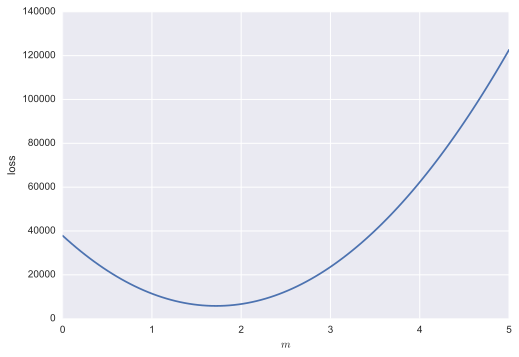

In [11]:
def wrongness_for_slope_guess(m):
    return wrongness(m, b, X.values, y.values)

ms = np.linspace(0,5,100)
losses = []
for m in ms:
    losses.append(wrongness_for_slope_guess(m))
plt.plot(ms, losses)
plt.xlabel('$m$')
plt.ylabel('loss')

there are other optimization methods such as genetic algorithms, particle swarm optimization, etc...

but gradient descent is by far the most common.